In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['trainset.csv', 'testset.csv']


In [2]:
def modifyDataset(data):
    trainset = data.iloc[:,1:2].values
    return trainset

In [3]:
dataset_train = pd.read_csv("../input/trainset.csv")
trainset = modifyDataset(dataset_train)
trainset

array([[ 357.385559],
       [ 360.122742],
       [ 362.313507],
       ...,
       [1057.390015],
       [1051.599976],
       [1046.719971]])

In [4]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0,1))
training_scaled = sc.fit_transform(trainset)
len(training_scaled)

1259

In [5]:
x_train = []
y_train = []
for i in range(50,1259):
    x_train.append(training_scaled[i-50:i, 0])
    y_train.append(training_scaled[i,0])
x_train,y_train = np.array(x_train),np.array(y_train)

In [6]:
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

In [7]:
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.layers import LSTM, GRU
from keras.layers import Dropout

Using TensorFlow backend.


In [9]:
regressor = Sequential()
regressor.add(GRU(units = 250,return_sequences = True,input_shape = (x_train.shape[1],1)))

regressor.add(GRU(units = 125,return_sequences = True))

regressor.add(GRU(units = 75,return_sequences = True))

regressor.add(GRU(units = 50,return_sequences = True))

regressor.add(Flatten())

regressor.add(Dense(units = 512, activation = 'relu'))
regressor.add(Dropout(0.2))

regressor.add(Dense(units = 256, activation = 'relu'))
regressor.add(Dropout(0.1))

regressor.add(Dense(units = 128, activation = 'relu'))
regressor.add(Dropout(0.1))

regressor.add(Dense(units = 64, activation = 'relu'))
regressor.add(Dropout(0.1))

regressor.add(Dense(units = 8, activation = 'relu'))

regressor.add(Dense(units = 1))

regressor.compile(optimizer = 'adam',loss = 'mean_absolute_error', metrics = ['accuracy'])

regressor.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_5 (GRU)                  (None, 50, 250)           189000    
_________________________________________________________________
gru_6 (GRU)                  (None, 50, 125)           141000    
_________________________________________________________________
gru_7 (GRU)                  (None, 50, 75)            45225     
_________________________________________________________________
gru_8 (GRU)                  (None, 50, 50)            18900     
_________________________________________________________________
flatten_2 (Flatten)          (None, 2500)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 512)               1280512   
_________________________________________________________________
dropout_6 (Dropout)          (None, 512)               0         
__________

In [22]:
regressor.fit(x_train,y_train,epochs = 5000, batch_size = 256)

Epoch 1/5000
1209/1209 [==============================] - 4s 4ms/step - loss: 0.0439 - acc: 8.2713e-04
Epoch 2/5000
1209/1209 [==============================] - 2s 1ms/step - loss: 0.0182 - acc: 8.2713e-04
Epoch 3/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0142 - acc: 8.2713e-04
Epoch 4/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0139 - acc: 8.2713e-04
Epoch 5/5000
1209/1209 [==============================] - 1s 1000us/step - loss: 0.0152 - acc: 8.2713e-04
Epoch 6/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0135 - acc: 8.2713e-04
Epoch 7/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0126 - acc: 8.2713e-04
Epoch 8/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0134 - acc: 8.2713e-04
Epoch 9/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0140 - acc: 8.2713e-04
Epoch 10/5000
1209/1209 [==============================] - 1s 999us/st

1209/1209 [==============================] - 1s 1ms/step - loss: 0.0150 - acc: 8.2713e-04
Epoch 80/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0139 - acc: 8.2713e-04
Epoch 81/5000
1209/1209 [==============================] - 2s 1ms/step - loss: 0.0119 - acc: 8.2713e-04
Epoch 82/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0115 - acc: 8.2713e-04
Epoch 83/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0118 - acc: 8.2713e-04
Epoch 84/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0114 - acc: 8.2713e-04
Epoch 85/5000
1209/1209 [==============================] - 1s 994us/step - loss: 0.0112 - acc: 8.2713e-04
Epoch 86/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0125 - acc: 8.2713e-04
Epoch 87/5000
1209/1209 [==============================] - 1s 993us/step - loss: 0.0132 - acc: 8.2713e-04
Epoch 88/5000
1209/1209 [==============================] - 1s 1ms/step - l

1209/1209 [==============================] - 1s 1ms/step - loss: 0.0127 - acc: 8.2713e-04
Epoch 158/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0121 - acc: 8.2713e-04
Epoch 159/5000
1209/1209 [==============================] - 1s 992us/step - loss: 0.0119 - acc: 8.2713e-04
Epoch 160/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0111 - acc: 8.2713e-04
Epoch 161/5000
1209/1209 [==============================] - 1s 989us/step - loss: 0.0121 - acc: 8.2713e-04
Epoch 162/5000
1209/1209 [==============================] - 2s 1ms/step - loss: 0.0119 - acc: 8.2713e-04
Epoch 163/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0126 - acc: 8.2713e-04
Epoch 164/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0123 - acc: 8.2713e-04
Epoch 165/5000
1209/1209 [==============================] - 2s 1ms/step - loss: 0.0134 - acc: 8.2713e-04
Epoch 166/5000
1209/1209 [==============================] - 1s 1ms

Epoch 235/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0107 - acc: 8.2713e-04
Epoch 236/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0109 - acc: 8.2713e-04
Epoch 237/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0116 - acc: 8.2713e-04
Epoch 238/5000
1209/1209 [==============================] - 2s 1ms/step - loss: 0.0109 - acc: 8.2713e-04
Epoch 239/5000
1209/1209 [==============================] - 2s 1ms/step - loss: 0.0110 - acc: 8.2713e-04
Epoch 240/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0109 - acc: 8.2713e-04
Epoch 241/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0101 - acc: 8.2713e-04
Epoch 242/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0113 - acc: 8.2713e-04
Epoch 243/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0113 - acc: 8.2713e-04
Epoch 244/5000
1209/1209 [=============================

1209/1209 [==============================] - 1s 1ms/step - loss: 0.0100 - acc: 8.2713e-04
Epoch 313/5000
1209/1209 [==============================] - 2s 1ms/step - loss: 0.0104 - acc: 8.2713e-04
Epoch 314/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0106 - acc: 8.2713e-04
Epoch 315/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0098 - acc: 8.2713e-04
Epoch 316/5000
1209/1209 [==============================] - 1s 992us/step - loss: 0.0105 - acc: 8.2713e-04
Epoch 317/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0105 - acc: 8.2713e-04
Epoch 318/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0104 - acc: 8.2713e-04
Epoch 319/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0102 - acc: 8.2713e-04
Epoch 320/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0094 - acc: 8.2713e-04
Epoch 321/5000
1209/1209 [==============================] - 2s 1ms/s

1209/1209 [==============================] - 2s 1ms/step - loss: 0.0106 - acc: 8.2713e-04
Epoch 390/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0095 - acc: 8.2713e-04
Epoch 391/5000
1209/1209 [==============================] - 2s 1ms/step - loss: 0.0096 - acc: 8.2713e-04
Epoch 392/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0101 - acc: 8.2713e-04
Epoch 393/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0102 - acc: 8.2713e-04
Epoch 394/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0106 - acc: 8.2713e-04
Epoch 395/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0121 - acc: 8.2713e-04
Epoch 396/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0095 - acc: 8.2713e-04
Epoch 397/5000
1209/1209 [==============================] - 2s 1ms/step - loss: 0.0102 - acc: 8.2713e-04
Epoch 398/5000
1209/1209 [==============================] - 1s 1ms/ste

1209/1209 [==============================] - 1s 1ms/step - loss: 0.0097 - acc: 8.2713e-04
Epoch 468/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0091 - acc: 8.2713e-04
Epoch 469/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0090 - acc: 8.2713e-04
Epoch 470/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0093 - acc: 8.2713e-04
Epoch 471/5000
1209/1209 [==============================] - 2s 1ms/step - loss: 0.0104 - acc: 8.2713e-04
Epoch 472/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0123 - acc: 8.2713e-04
Epoch 473/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0118 - acc: 8.2713e-04
Epoch 474/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0111 - acc: 8.2713e-04
Epoch 475/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0096 - acc: 8.2713e-04
Epoch 476/5000
1209/1209 [==============================] - 1s 1ms/ste

1209/1209 [==============================] - 1s 1ms/step - loss: 0.0098 - acc: 8.2713e-04
Epoch 546/5000
1209/1209 [==============================] - 1s 995us/step - loss: 0.0086 - acc: 8.2713e-04
Epoch 547/5000
1209/1209 [==============================] - 1s 991us/step - loss: 0.0091 - acc: 8.2713e-04
Epoch 548/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0089 - acc: 8.2713e-04
Epoch 549/5000
1209/1209 [==============================] - 1s 985us/step - loss: 0.0095 - acc: 8.2713e-04
Epoch 550/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0093 - acc: 8.2713e-04
Epoch 551/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0090 - acc: 8.2713e-04
Epoch 552/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0087 - acc: 8.2713e-04
Epoch 553/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0087 - acc: 8.2713e-04
Epoch 554/5000
1209/1209 [==============================] - 2s 1

1209/1209 [==============================] - 1s 1ms/step - loss: 0.0102 - acc: 8.2713e-04
Epoch 623/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0091 - acc: 8.2713e-04
Epoch 624/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0085 - acc: 8.2713e-04
Epoch 625/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0087 - acc: 8.2713e-04
Epoch 626/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0087 - acc: 8.2713e-04
Epoch 627/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0087 - acc: 8.2713e-04
Epoch 628/5000
1209/1209 [==============================] - 2s 1ms/step - loss: 0.0083 - acc: 8.2713e-04
Epoch 629/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0094 - acc: 8.2713e-04
Epoch 630/5000
1209/1209 [==============================] - 1s 991us/step - loss: 0.0089 - acc: 8.2713e-04
Epoch 631/5000
1209/1209 [==============================] - 1s 1ms/s

1209/1209 [==============================] - 1s 1ms/step - loss: 0.0090 - acc: 8.2713e-04
Epoch 701/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0080 - acc: 8.2713e-04
Epoch 702/5000
1209/1209 [==============================] - 2s 2ms/step - loss: 0.0082 - acc: 8.2713e-04
Epoch 703/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0083 - acc: 8.2713e-04
Epoch 704/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0078 - acc: 8.2713e-04
Epoch 705/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0077 - acc: 8.2713e-04
Epoch 706/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0078 - acc: 8.2713e-04
Epoch 707/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0086 - acc: 8.2713e-04
Epoch 708/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0076 - acc: 8.2713e-04
Epoch 709/5000
1209/1209 [==============================] - 2s 1ms/ste

1209/1209 [==============================] - 1s 1ms/step - loss: 0.0086 - acc: 8.2713e-04
Epoch 779/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0080 - acc: 8.2713e-04
Epoch 780/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0080 - acc: 8.2713e-04
Epoch 781/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0075 - acc: 8.2713e-04
Epoch 782/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0077 - acc: 8.2713e-04
Epoch 783/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0077 - acc: 8.2713e-04
Epoch 784/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0081 - acc: 8.2713e-04
Epoch 785/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0082 - acc: 8.2713e-04
Epoch 786/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0083 - acc: 8.2713e-04
Epoch 787/5000
1209/1209 [==============================] - 1s 995us/s

1209/1209 [==============================] - 1s 1ms/step - loss: 0.0086 - acc: 8.2713e-04
Epoch 857/5000
1209/1209 [==============================] - 2s 1ms/step - loss: 0.0085 - acc: 8.2713e-04
Epoch 858/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0085 - acc: 8.2713e-04
Epoch 859/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0087 - acc: 8.2713e-04
Epoch 860/5000
1209/1209 [==============================] - 1s 999us/step - loss: 0.0082 - acc: 8.2713e-04
Epoch 861/5000
1209/1209 [==============================] - 1s 998us/step - loss: 0.0073 - acc: 8.2713e-04
Epoch 862/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0079 - acc: 8.2713e-04
Epoch 863/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0083 - acc: 8.2713e-04
Epoch 864/5000
1209/1209 [==============================] - 1s 987us/step - loss: 0.0075 - acc: 8.2713e-04
Epoch 865/5000
1209/1209 [==============================] - 1s 1

1209/1209 [==============================] - 1s 1ms/step - loss: 0.0084 - acc: 8.2713e-04
Epoch 935/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0101 - acc: 8.2713e-04
Epoch 936/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0102 - acc: 8.2713e-04
Epoch 937/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0093 - acc: 8.2713e-04
Epoch 938/5000
1209/1209 [==============================] - 2s 1ms/step - loss: 0.0091 - acc: 8.2713e-04
Epoch 939/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0088 - acc: 8.2713e-04
Epoch 940/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0080 - acc: 8.2713e-04
Epoch 941/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0072 - acc: 8.2713e-04
Epoch 942/5000
1209/1209 [==============================] - 1s 998us/step - loss: 0.0072 - acc: 8.2713e-04
Epoch 943/5000
1209/1209 [==============================] - 1s 1ms/s

1209/1209 [==============================] - 1s 999us/step - loss: 0.0084 - acc: 8.2713e-04
Epoch 1012/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0086 - acc: 8.2713e-04
Epoch 1013/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0090 - acc: 8.2713e-04
Epoch 1014/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0076 - acc: 8.2713e-04
Epoch 1015/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0074 - acc: 8.2713e-04
Epoch 1016/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0071 - acc: 8.2713e-04
Epoch 1017/5000
1209/1209 [==============================] - 2s 1ms/step - loss: 0.0074 - acc: 8.2713e-04
Epoch 1018/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0074 - acc: 8.2713e-04
Epoch 1019/5000
1209/1209 [==============================] - 2s 1ms/step - loss: 0.0073 - acc: 8.2713e-04
Epoch 1020/5000
1209/1209 [==============================] -

1209/1209 [==============================] - 1s 1ms/step - loss: 0.0069 - acc: 8.2713e-04
Epoch 1089/5000
1209/1209 [==============================] - 1s 997us/step - loss: 0.0073 - acc: 8.2713e-04
Epoch 1090/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0067 - acc: 8.2713e-04
Epoch 1091/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0070 - acc: 8.2713e-04
Epoch 1092/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0071 - acc: 8.2713e-04
Epoch 1093/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0076 - acc: 8.2713e-04
Epoch 1094/5000
1209/1209 [==============================] - 2s 1ms/step - loss: 0.0082 - acc: 8.2713e-04
Epoch 1095/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0079 - acc: 8.2713e-04
Epoch 1096/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0084 - acc: 8.2713e-04
Epoch 1097/5000
1209/1209 [==============================] -

1209/1209 [==============================] - 1s 1ms/step - loss: 0.0067 - acc: 8.2713e-04
Epoch 1166/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0067 - acc: 8.2713e-04
Epoch 1167/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0069 - acc: 8.2713e-04
Epoch 1168/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0074 - acc: 8.2713e-04
Epoch 1169/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0074 - acc: 8.2713e-04
Epoch 1170/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0079 - acc: 8.2713e-04
Epoch 1171/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0074 - acc: 8.2713e-04
Epoch 1172/5000
1209/1209 [==============================] - 1s 997us/step - loss: 0.0069 - acc: 8.2713e-04
Epoch 1173/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0074 - acc: 8.2713e-04
Epoch 1174/5000
1209/1209 [==============================] -

1209/1209 [==============================] - 1s 1ms/step - loss: 0.0068 - acc: 8.2713e-04
Epoch 1243/5000
1209/1209 [==============================] - 2s 1ms/step - loss: 0.0075 - acc: 8.2713e-04
Epoch 1244/5000
1209/1209 [==============================] - 2s 1ms/step - loss: 0.0075 - acc: 8.2713e-04
Epoch 1245/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0066 - acc: 8.2713e-04
Epoch 1246/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0073 - acc: 8.2713e-04
Epoch 1247/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0074 - acc: 8.2713e-04
Epoch 1248/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0092 - acc: 8.2713e-04
Epoch 1249/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0091 - acc: 8.2713e-04
Epoch 1250/5000
1209/1209 [==============================] - 2s 1ms/step - loss: 0.0092 - acc: 8.2713e-04
Epoch 1251/5000
1209/1209 [==============================] - 2

1209/1209 [==============================] - 1s 1ms/step - loss: 0.0064 - acc: 8.2713e-04
Epoch 1320/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0064 - acc: 8.2713e-04
Epoch 1321/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0069 - acc: 8.2713e-04
Epoch 1322/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0063 - acc: 8.2713e-04
Epoch 1323/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0066 - acc: 8.2713e-04
Epoch 1324/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0070 - acc: 8.2713e-04
Epoch 1325/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0069 - acc: 8.2713e-04
Epoch 1326/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0082 - acc: 8.2713e-04
Epoch 1327/5000
1209/1209 [==============================] - 2s 1ms/step - loss: 0.0079 - acc: 8.2713e-04
Epoch 1328/5000
1209/1209 [==============================] - 1

1209/1209 [==============================] - 1s 1ms/step - loss: 0.0074 - acc: 8.2713e-04
Epoch 1397/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0074 - acc: 8.2713e-04
Epoch 1398/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0066 - acc: 8.2713e-04
Epoch 1399/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0077 - acc: 8.2713e-04
Epoch 1400/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0067 - acc: 8.2713e-04
Epoch 1401/5000
1209/1209 [==============================] - 2s 1ms/step - loss: 0.0065 - acc: 8.2713e-04
Epoch 1402/5000
1209/1209 [==============================] - 1s 999us/step - loss: 0.0077 - acc: 8.2713e-04
Epoch 1403/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0078 - acc: 8.2713e-04
Epoch 1404/5000
1209/1209 [==============================] - 1s 990us/step - loss: 0.0063 - acc: 8.2713e-04
Epoch 1405/5000
1209/1209 [==============================]

1209/1209 [==============================] - 1s 1ms/step - loss: 0.0065 - acc: 8.2713e-04
Epoch 1474/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0060 - acc: 8.2713e-04
Epoch 1475/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0062 - acc: 8.2713e-04
Epoch 1476/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0061 - acc: 8.2713e-04
Epoch 1477/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0062 - acc: 8.2713e-04
Epoch 1478/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0059 - acc: 8.2713e-04
Epoch 1479/5000
1209/1209 [==============================] - 1s 990us/step - loss: 0.0061 - acc: 8.2713e-04
Epoch 1480/5000
1209/1209 [==============================] - 1s 992us/step - loss: 0.0062 - acc: 8.2713e-04
Epoch 1481/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0067 - acc: 8.2713e-04
Epoch 1482/5000
1209/1209 [==============================]

1209/1209 [==============================] - 1s 1ms/step - loss: 0.0063 - acc: 8.2713e-04
Epoch 1551/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0069 - acc: 8.2713e-04
Epoch 1552/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0070 - acc: 8.2713e-04
Epoch 1553/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0067 - acc: 8.2713e-04
Epoch 1554/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0071 - acc: 8.2713e-04
Epoch 1555/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0066 - acc: 8.2713e-04
Epoch 1556/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0066 - acc: 8.2713e-04
Epoch 1557/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0064 - acc: 8.2713e-04
Epoch 1558/5000
1209/1209 [==============================] - 2s 1ms/step - loss: 0.0070 - acc: 8.2713e-04
Epoch 1559/5000
1209/1209 [==============================] - 1

1209/1209 [==============================] - 1s 1ms/step - loss: 0.0058 - acc: 8.2713e-04
Epoch 1628/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0061 - acc: 8.2713e-04
Epoch 1629/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0058 - acc: 8.2713e-04
Epoch 1630/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0064 - acc: 8.2713e-04
Epoch 1631/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0071 - acc: 8.2713e-04
Epoch 1632/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0075 - acc: 8.2713e-04
Epoch 1633/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0069 - acc: 8.2713e-04
Epoch 1634/5000
1209/1209 [==============================] - 2s 1ms/step - loss: 0.0061 - acc: 8.2713e-04
Epoch 1635/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0065 - acc: 8.2713e-04
Epoch 1636/5000
1209/1209 [==============================] - 1

1209/1209 [==============================] - 1s 1ms/step - loss: 0.0064 - acc: 8.2713e-04
Epoch 1705/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0067 - acc: 8.2713e-04
Epoch 1706/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0063 - acc: 8.2713e-04
Epoch 1707/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0060 - acc: 8.2713e-04
Epoch 1708/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0062 - acc: 8.2713e-04
Epoch 1709/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0063 - acc: 8.2713e-04
Epoch 1710/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0057 - acc: 8.2713e-04
Epoch 1711/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0060 - acc: 8.2713e-04
Epoch 1712/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0059 - acc: 8.2713e-04
Epoch 1713/5000
1209/1209 [==============================] - 1

1209/1209 [==============================] - 1s 1ms/step - loss: 0.0070 - acc: 8.2713e-04
Epoch 1782/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0063 - acc: 8.2713e-04
Epoch 1783/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0069 - acc: 8.2713e-04
Epoch 1784/5000
1209/1209 [==============================] - 2s 2ms/step - loss: 0.0060 - acc: 8.2713e-04
Epoch 1785/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0059 - acc: 8.2713e-04
Epoch 1786/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0065 - acc: 8.2713e-04
Epoch 1787/5000
1209/1209 [==============================] - 2s 1ms/step - loss: 0.0079 - acc: 8.2713e-04
Epoch 1788/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0071 - acc: 8.2713e-04
Epoch 1789/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0073 - acc: 8.2713e-04
Epoch 1790/5000
1209/1209 [==============================] - 1

1209/1209 [==============================] - 1s 1ms/step - loss: 0.0059 - acc: 8.2713e-04
Epoch 1859/5000
1209/1209 [==============================] - 2s 1ms/step - loss: 0.0050 - acc: 8.2713e-04
Epoch 1860/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0060 - acc: 8.2713e-04
Epoch 1861/5000
1209/1209 [==============================] - 1s 994us/step - loss: 0.0062 - acc: 8.2713e-04
Epoch 1862/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0059 - acc: 8.2713e-04
Epoch 1863/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0057 - acc: 8.2713e-04
Epoch 1864/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0064 - acc: 8.2713e-04
Epoch 1865/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0061 - acc: 8.2713e-04
Epoch 1866/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0056 - acc: 8.2713e-04
Epoch 1867/5000
1209/1209 [==============================] -

1209/1209 [==============================] - 1s 1ms/step - loss: 0.0061 - acc: 8.2713e-04
Epoch 1936/5000
1209/1209 [==============================] - 1s 988us/step - loss: 0.0063 - acc: 8.2713e-04
Epoch 1937/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0071 - acc: 8.2713e-04
Epoch 1938/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0073 - acc: 8.2713e-04
Epoch 1939/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0070 - acc: 8.2713e-04
Epoch 1940/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0065 - acc: 8.2713e-04
Epoch 1941/5000
1209/1209 [==============================] - 2s 1ms/step - loss: 0.0060 - acc: 8.2713e-04
Epoch 1942/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0066 - acc: 8.2713e-04
Epoch 1943/5000
1209/1209 [==============================] - 1s 997us/step - loss: 0.0063 - acc: 8.2713e-04
Epoch 1944/5000
1209/1209 [==============================]

1209/1209 [==============================] - 1s 1ms/step - loss: 0.0061 - acc: 8.2713e-04
Epoch 2013/5000
1209/1209 [==============================] - 2s 1ms/step - loss: 0.0060 - acc: 8.2713e-04
Epoch 2014/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0056 - acc: 8.2713e-04
Epoch 2015/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0057 - acc: 8.2713e-04
Epoch 2016/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0054 - acc: 8.2713e-04
Epoch 2017/5000
1209/1209 [==============================] - 2s 1ms/step - loss: 0.0056 - acc: 8.2713e-04
Epoch 2018/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0055 - acc: 8.2713e-04
Epoch 2019/5000
1209/1209 [==============================] - 2s 1ms/step - loss: 0.0057 - acc: 8.2713e-04
Epoch 2020/5000
1209/1209 [==============================] - 2s 1ms/step - loss: 0.0058 - acc: 8.2713e-04
Epoch 2021/5000
1209/1209 [==============================] - 1

1209/1209 [==============================] - 2s 1ms/step - loss: 0.0057 - acc: 8.2713e-04
Epoch 2090/5000
1209/1209 [==============================] - 2s 2ms/step - loss: 0.0055 - acc: 8.2713e-04
Epoch 2091/5000
1209/1209 [==============================] - 2s 1ms/step - loss: 0.0058 - acc: 8.2713e-04
Epoch 2092/5000
1209/1209 [==============================] - 2s 2ms/step - loss: 0.0058 - acc: 8.2713e-04
Epoch 2093/5000
1209/1209 [==============================] - 2s 1ms/step - loss: 0.0059 - acc: 8.2713e-04
Epoch 2094/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0052 - acc: 8.2713e-04
Epoch 2095/5000
1209/1209 [==============================] - 2s 1ms/step - loss: 0.0055 - acc: 8.2713e-04
Epoch 2096/5000
1209/1209 [==============================] - 2s 1ms/step - loss: 0.0060 - acc: 8.2713e-04
Epoch 2097/5000
1209/1209 [==============================] - 2s 1ms/step - loss: 0.0057 - acc: 8.2713e-04
Epoch 2098/5000
1209/1209 [==============================] - 1

1209/1209 [==============================] - 1s 1ms/step - loss: 0.0050 - acc: 8.2713e-04
Epoch 2167/5000
1209/1209 [==============================] - 2s 1ms/step - loss: 0.0049 - acc: 8.2713e-04
Epoch 2168/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0052 - acc: 8.2713e-04
Epoch 2169/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0052 - acc: 8.2713e-04
Epoch 2170/5000
1209/1209 [==============================] - 1s 997us/step - loss: 0.0049 - acc: 8.2713e-04
Epoch 2171/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0051 - acc: 8.2713e-04
Epoch 2172/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0055 - acc: 8.2713e-04
Epoch 2173/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0056 - acc: 8.2713e-04
Epoch 2174/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0053 - acc: 8.2713e-04
Epoch 2175/5000
1209/1209 [==============================] -

1209/1209 [==============================] - 1s 1ms/step - loss: 0.0069 - acc: 8.2713e-04
Epoch 2244/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0060 - acc: 8.2713e-04
Epoch 2245/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0054 - acc: 8.2713e-04
Epoch 2246/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0052 - acc: 8.2713e-04
Epoch 2247/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0055 - acc: 8.2713e-04
Epoch 2248/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0053 - acc: 8.2713e-04
Epoch 2249/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0055 - acc: 8.2713e-04
Epoch 2250/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0061 - acc: 8.2713e-04
Epoch 2251/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0055 - acc: 8.2713e-04
Epoch 2252/5000
1209/1209 [==============================] - 1

1209/1209 [==============================] - 1s 1ms/step - loss: 0.0046 - acc: 8.2713e-04
Epoch 2321/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0051 - acc: 8.2713e-04
Epoch 2322/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0053 - acc: 8.2713e-04
Epoch 2323/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0052 - acc: 8.2713e-04
Epoch 2324/5000
1209/1209 [==============================] - 2s 1ms/step - loss: 0.0050 - acc: 8.2713e-04
Epoch 2325/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0055 - acc: 8.2713e-04
Epoch 2326/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0054 - acc: 8.2713e-04
Epoch 2327/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0055 - acc: 8.2713e-04
Epoch 2328/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0048 - acc: 8.2713e-04
Epoch 2329/5000
1209/1209 [==============================] - 1

1209/1209 [==============================] - 1s 1ms/step - loss: 0.0054 - acc: 8.2713e-04
Epoch 2398/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0052 - acc: 8.2713e-04
Epoch 2399/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0051 - acc: 8.2713e-04
Epoch 2400/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0055 - acc: 8.2713e-04
Epoch 2401/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0051 - acc: 8.2713e-04
Epoch 2402/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0057 - acc: 8.2713e-04
Epoch 2403/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0048 - acc: 8.2713e-04
Epoch 2404/5000
1209/1209 [==============================] - 2s 1ms/step - loss: 0.0051 - acc: 8.2713e-04
Epoch 2405/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0051 - acc: 8.2713e-04
Epoch 2406/5000
1209/1209 [==============================] - 1

1209/1209 [==============================] - 1s 1ms/step - loss: 0.0050 - acc: 8.2713e-04
Epoch 2475/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0052 - acc: 8.2713e-04
Epoch 2476/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0054 - acc: 8.2713e-04
Epoch 2477/5000
1209/1209 [==============================] - 2s 1ms/step - loss: 0.0050 - acc: 8.2713e-04
Epoch 2478/5000
1209/1209 [==============================] - 2s 1ms/step - loss: 0.0048 - acc: 8.2713e-04
Epoch 2479/5000
1209/1209 [==============================] - 2s 2ms/step - loss: 0.0050 - acc: 8.2713e-04
Epoch 2480/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0049 - acc: 8.2713e-04
Epoch 2481/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0054 - acc: 8.2713e-04
Epoch 2482/5000
1209/1209 [==============================] - 2s 1ms/step - loss: 0.0051 - acc: 8.2713e-04
Epoch 2483/5000
1209/1209 [==============================] - 1

1209/1209 [==============================] - 1s 1ms/step - loss: 0.0050 - acc: 8.2713e-04
Epoch 2552/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0047 - acc: 8.2713e-04
Epoch 2553/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0044 - acc: 8.2713e-04
Epoch 2554/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0046 - acc: 8.2713e-04
Epoch 2555/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0050 - acc: 8.2713e-04
Epoch 2556/5000
1209/1209 [==============================] - 1s 995us/step - loss: 0.0052 - acc: 8.2713e-04
Epoch 2557/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0049 - acc: 8.2713e-04
Epoch 2558/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0053 - acc: 8.2713e-04
Epoch 2559/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0050 - acc: 8.2713e-04
Epoch 2560/5000
1209/1209 [==============================] -

1209/1209 [==============================] - 1s 999us/step - loss: 0.0074 - acc: 8.2713e-04
Epoch 2629/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0073 - acc: 8.2713e-04
Epoch 2630/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0061 - acc: 8.2713e-04
Epoch 2631/5000
1209/1209 [==============================] - 2s 1ms/step - loss: 0.0062 - acc: 8.2713e-04
Epoch 2632/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0060 - acc: 8.2713e-04
Epoch 2633/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0057 - acc: 8.2713e-04
Epoch 2634/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0051 - acc: 8.2713e-04
Epoch 2635/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0055 - acc: 8.2713e-04
Epoch 2636/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0056 - acc: 8.2713e-04
Epoch 2637/5000
1209/1209 [==============================] -

1209/1209 [==============================] - 1s 1ms/step - loss: 0.0051 - acc: 8.2713e-04
Epoch 2706/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0057 - acc: 8.2713e-04
Epoch 2707/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0054 - acc: 8.2713e-04
Epoch 2708/5000
1209/1209 [==============================] - 1s 994us/step - loss: 0.0045 - acc: 8.2713e-04
Epoch 2709/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0049 - acc: 8.2713e-04
Epoch 2710/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0048 - acc: 8.2713e-04
Epoch 2711/5000
1209/1209 [==============================] - 2s 1ms/step - loss: 0.0052 - acc: 8.2713e-04
Epoch 2712/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0056 - acc: 8.2713e-04
Epoch 2713/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0054 - acc: 8.2713e-04
Epoch 2714/5000
1209/1209 [==============================] -

1209/1209 [==============================] - 1s 1ms/step - loss: 0.0042 - acc: 8.2713e-04
Epoch 2783/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0045 - acc: 8.2713e-04
Epoch 2784/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0051 - acc: 8.2713e-04
Epoch 2785/5000
1209/1209 [==============================] - 2s 1ms/step - loss: 0.0057 - acc: 8.2713e-04
Epoch 2786/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0049 - acc: 8.2713e-04
Epoch 2787/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0050 - acc: 8.2713e-04
Epoch 2788/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0051 - acc: 8.2713e-04
Epoch 2789/5000
1209/1209 [==============================] - 2s 1ms/step - loss: 0.0051 - acc: 8.2713e-04
Epoch 2790/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0049 - acc: 8.2713e-04
Epoch 2791/5000
1209/1209 [==============================] - 1

1209/1209 [==============================] - 2s 1ms/step - loss: 0.0055 - acc: 8.2713e-04
Epoch 2860/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0051 - acc: 8.2713e-04
Epoch 2861/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0050 - acc: 8.2713e-04
Epoch 2862/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0052 - acc: 8.2713e-04
Epoch 2863/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0049 - acc: 8.2713e-04
Epoch 2864/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0052 - acc: 8.2713e-04
Epoch 2865/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0050 - acc: 8.2713e-04
Epoch 2866/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0048 - acc: 8.2713e-04
Epoch 2867/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0046 - acc: 8.2713e-04
Epoch 2868/5000
1209/1209 [==============================] - 2

1209/1209 [==============================] - 1s 1ms/step - loss: 0.0048 - acc: 8.2713e-04
Epoch 2937/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0052 - acc: 8.2713e-04
Epoch 2938/5000
1209/1209 [==============================] - 1s 997us/step - loss: 0.0051 - acc: 8.2713e-04
Epoch 2939/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0058 - acc: 8.2713e-04
Epoch 2940/5000
1209/1209 [==============================] - 1s 992us/step - loss: 0.0061 - acc: 8.2713e-04
Epoch 2941/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0064 - acc: 8.2713e-04
Epoch 2942/5000
1209/1209 [==============================] - 2s 1ms/step - loss: 0.0066 - acc: 8.2713e-04
Epoch 2943/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0054 - acc: 8.2713e-04
Epoch 2944/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0053 - acc: 8.2713e-04
Epoch 2945/5000
1209/1209 [==============================]

1209/1209 [==============================] - 1s 1000us/step - loss: 0.0047 - acc: 8.2713e-04
Epoch 3014/5000
1209/1209 [==============================] - 2s 1ms/step - loss: 0.0047 - acc: 8.2713e-04
Epoch 3015/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0044 - acc: 8.2713e-04
Epoch 3016/5000
1209/1209 [==============================] - 2s 1ms/step - loss: 0.0044 - acc: 8.2713e-04
Epoch 3017/5000
1209/1209 [==============================] - 2s 1ms/step - loss: 0.0044 - acc: 8.2713e-04
Epoch 3018/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0047 - acc: 8.2713e-04
Epoch 3019/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0053 - acc: 8.2713e-04
Epoch 3020/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0053 - acc: 8.2713e-04
Epoch 3021/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0049 - acc: 8.2713e-04
Epoch 3022/5000
1209/1209 [==============================] 

1209/1209 [==============================] - 2s 1ms/step - loss: 0.0046 - acc: 8.2713e-04
Epoch 3091/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0046 - acc: 8.2713e-04
Epoch 3092/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0044 - acc: 8.2713e-04
Epoch 3093/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0045 - acc: 8.2713e-04
Epoch 3094/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0042 - acc: 8.2713e-04
Epoch 3095/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0048 - acc: 8.2713e-04
Epoch 3096/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0047 - acc: 8.2713e-04
Epoch 3097/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0046 - acc: 8.2713e-04
Epoch 3098/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0043 - acc: 8.2713e-04
Epoch 3099/5000
1209/1209 [==============================] - 1

1209/1209 [==============================] - 1s 1ms/step - loss: 0.0042 - acc: 8.2713e-04
Epoch 3168/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0046 - acc: 8.2713e-04
Epoch 3169/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0044 - acc: 8.2713e-04
Epoch 3170/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0043 - acc: 8.2713e-04
Epoch 3171/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0047 - acc: 8.2713e-04
Epoch 3172/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0049 - acc: 8.2713e-04
Epoch 3173/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0040 - acc: 8.2713e-04
Epoch 3174/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0046 - acc: 8.2713e-04
Epoch 3175/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0050 - acc: 8.2713e-04
Epoch 3176/5000
1209/1209 [==============================] - 1

1209/1209 [==============================] - 1s 1ms/step - loss: 0.0039 - acc: 8.2713e-04
Epoch 3245/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0047 - acc: 8.2713e-04
Epoch 3246/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0045 - acc: 8.2713e-04
Epoch 3247/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0044 - acc: 8.2713e-04
Epoch 3248/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0046 - acc: 8.2713e-04
Epoch 3249/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0049 - acc: 8.2713e-04
Epoch 3250/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0049 - acc: 8.2713e-04
Epoch 3251/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0047 - acc: 8.2713e-04
Epoch 3252/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0057 - acc: 8.2713e-04
Epoch 3253/5000
1209/1209 [==============================] - 1

1209/1209 [==============================] - 1s 1ms/step - loss: 0.0047 - acc: 8.2713e-04
Epoch 3322/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0046 - acc: 8.2713e-04
Epoch 3323/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0042 - acc: 8.2713e-04
Epoch 3324/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0049 - acc: 8.2713e-04
Epoch 3325/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0045 - acc: 8.2713e-04
Epoch 3326/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0044 - acc: 8.2713e-04
Epoch 3327/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0046 - acc: 8.2713e-04
Epoch 3328/5000
1209/1209 [==============================] - 2s 2ms/step - loss: 0.0042 - acc: 8.2713e-04
Epoch 3329/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0043 - acc: 8.2713e-04
Epoch 3330/5000
1209/1209 [==============================] - 1

1209/1209 [==============================] - 1s 1ms/step - loss: 0.0051 - acc: 8.2713e-04
Epoch 3399/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0043 - acc: 8.2713e-04
Epoch 3400/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0044 - acc: 8.2713e-04
Epoch 3401/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0048 - acc: 8.2713e-04
Epoch 3402/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0045 - acc: 8.2713e-04
Epoch 3403/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0048 - acc: 8.2713e-04
Epoch 3404/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0043 - acc: 8.2713e-04
Epoch 3405/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0042 - acc: 8.2713e-04
Epoch 3406/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0043 - acc: 8.2713e-04
Epoch 3407/5000
1209/1209 [==============================] - 2

1209/1209 [==============================] - 2s 1ms/step - loss: 0.0043 - acc: 8.2713e-04
Epoch 3476/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0048 - acc: 8.2713e-04
Epoch 3477/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0048 - acc: 8.2713e-04
Epoch 3478/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0042 - acc: 8.2713e-04
Epoch 3479/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0045 - acc: 8.2713e-04
Epoch 3480/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0042 - acc: 8.2713e-04
Epoch 3481/5000
1209/1209 [==============================] - 1s 993us/step - loss: 0.0043 - acc: 8.2713e-04
Epoch 3482/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0039 - acc: 8.2713e-04
Epoch 3483/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0036 - acc: 8.2713e-04
Epoch 3484/5000
1209/1209 [==============================] -

1209/1209 [==============================] - 1s 1ms/step - loss: 0.0046 - acc: 8.2713e-04
Epoch 3553/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0042 - acc: 8.2713e-04
Epoch 3554/5000
1209/1209 [==============================] - 2s 1ms/step - loss: 0.0040 - acc: 8.2713e-04
Epoch 3555/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0044 - acc: 8.2713e-04
Epoch 3556/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0047 - acc: 8.2713e-04
Epoch 3557/5000
1209/1209 [==============================] - 2s 1ms/step - loss: 0.0042 - acc: 8.2713e-04
Epoch 3558/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0044 - acc: 8.2713e-04
Epoch 3559/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0042 - acc: 8.2713e-04
Epoch 3560/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0047 - acc: 8.2713e-04
Epoch 3561/5000
1209/1209 [==============================] - 1

1209/1209 [==============================] - 1s 993us/step - loss: 0.0040 - acc: 8.2713e-04
Epoch 3630/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0041 - acc: 8.2713e-04
Epoch 3631/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0042 - acc: 8.2713e-04
Epoch 3632/5000
1209/1209 [==============================] - 1s 994us/step - loss: 0.0038 - acc: 8.2713e-04
Epoch 3633/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0039 - acc: 8.2713e-04
Epoch 3634/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0038 - acc: 8.2713e-04
Epoch 3635/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0040 - acc: 8.2713e-04
Epoch 3636/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0043 - acc: 8.2713e-04
Epoch 3637/5000
1209/1209 [==============================] - 1s 995us/step - loss: 0.0041 - acc: 8.2713e-04
Epoch 3638/5000
1209/1209 [=============================

1209/1209 [==============================] - 1s 1ms/step - loss: 0.0041 - acc: 8.2713e-04
Epoch 3707/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0042 - acc: 8.2713e-04
Epoch 3708/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0041 - acc: 8.2713e-04
Epoch 3709/5000
1209/1209 [==============================] - 1s 999us/step - loss: 0.0041 - acc: 8.2713e-04
Epoch 3710/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0049 - acc: 8.2713e-04
Epoch 3711/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0049 - acc: 8.2713e-04
Epoch 3712/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0048 - acc: 8.2713e-04
Epoch 3713/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0040 - acc: 8.2713e-04
Epoch 3714/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0045 - acc: 8.2713e-04
Epoch 3715/5000
1209/1209 [==============================] -

1209/1209 [==============================] - 1s 1ms/step - loss: 0.0050 - acc: 8.2713e-04
Epoch 3784/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0050 - acc: 8.2713e-04
Epoch 3785/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0050 - acc: 8.2713e-04
Epoch 3786/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0054 - acc: 8.2713e-04
Epoch 3787/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0052 - acc: 8.2713e-04
Epoch 3788/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0042 - acc: 8.2713e-04
Epoch 3789/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0041 - acc: 8.2713e-04
Epoch 3790/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0045 - acc: 8.2713e-04
Epoch 3791/5000
1209/1209 [==============================] - 1s 987us/step - loss: 0.0047 - acc: 8.2713e-04
Epoch 3792/5000
1209/1209 [==============================] -

1209/1209 [==============================] - 1s 1ms/step - loss: 0.0039 - acc: 8.2713e-04
Epoch 3861/5000
1209/1209 [==============================] - 1s 990us/step - loss: 0.0041 - acc: 8.2713e-04
Epoch 3862/5000
1209/1209 [==============================] - 1s 991us/step - loss: 0.0039 - acc: 8.2713e-04
Epoch 3863/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0041 - acc: 8.2713e-04
Epoch 3864/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0042 - acc: 8.2713e-04
Epoch 3865/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0039 - acc: 8.2713e-04
Epoch 3866/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0043 - acc: 8.2713e-04
Epoch 3867/5000
1209/1209 [==============================] - 2s 1ms/step - loss: 0.0040 - acc: 8.2713e-04
Epoch 3868/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0044 - acc: 8.2713e-04
Epoch 3869/5000
1209/1209 [==============================]

1209/1209 [==============================] - 1s 1ms/step - loss: 0.0041 - acc: 8.2713e-04
Epoch 3938/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0043 - acc: 8.2713e-04
Epoch 3939/5000
1209/1209 [==============================] - 2s 1ms/step - loss: 0.0041 - acc: 8.2713e-04
Epoch 3940/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0045 - acc: 8.2713e-04
Epoch 3941/5000
1209/1209 [==============================] - 1s 981us/step - loss: 0.0038 - acc: 8.2713e-04
Epoch 3942/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0039 - acc: 8.2713e-04
Epoch 3943/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0046 - acc: 8.2713e-04
Epoch 3944/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0054 - acc: 8.2713e-04
Epoch 3945/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0046 - acc: 8.2713e-04
Epoch 3946/5000
1209/1209 [==============================] -

1209/1209 [==============================] - 1s 1ms/step - loss: 0.0043 - acc: 8.2713e-04
Epoch 4015/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0046 - acc: 8.2713e-04
Epoch 4016/5000
1209/1209 [==============================] - 1s 999us/step - loss: 0.0041 - acc: 8.2713e-04
Epoch 4017/5000
1209/1209 [==============================] - 1s 983us/step - loss: 0.0041 - acc: 8.2713e-04
Epoch 4018/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0037 - acc: 8.2713e-04
Epoch 4019/5000
1209/1209 [==============================] - 1s 994us/step - loss: 0.0040 - acc: 8.2713e-04
Epoch 4020/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0043 - acc: 8.2713e-04
Epoch 4021/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0042 - acc: 8.2713e-04
Epoch 4022/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0042 - acc: 8.2713e-04
Epoch 4023/5000
1209/1209 [=============================

1209/1209 [==============================] - 1s 995us/step - loss: 0.0036 - acc: 8.2713e-04
Epoch 4092/5000
1209/1209 [==============================] - 1s 992us/step - loss: 0.0042 - acc: 8.2713e-04
Epoch 4093/5000
1209/1209 [==============================] - 2s 1ms/step - loss: 0.0040 - acc: 8.2713e-04
Epoch 4094/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0037 - acc: 8.2713e-04
Epoch 4095/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0040 - acc: 8.2713e-04
Epoch 4096/5000
1209/1209 [==============================] - 2s 1ms/step - loss: 0.0038 - acc: 8.2713e-04
Epoch 4097/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0038 - acc: 8.2713e-04
Epoch 4098/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0041 - acc: 8.2713e-04
Epoch 4099/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0037 - acc: 8.2713e-04
Epoch 4100/5000
1209/1209 [==============================]

1209/1209 [==============================] - 1s 1ms/step - loss: 0.0045 - acc: 8.2713e-04
Epoch 4169/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0038 - acc: 8.2713e-04
Epoch 4170/5000
1209/1209 [==============================] - 2s 1ms/step - loss: 0.0045 - acc: 8.2713e-04
Epoch 4171/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0042 - acc: 8.2713e-04
Epoch 4172/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0042 - acc: 8.2713e-04
Epoch 4173/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0040 - acc: 8.2713e-04
Epoch 4174/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0046 - acc: 8.2713e-04
Epoch 4175/5000
1209/1209 [==============================] - 1s 996us/step - loss: 0.0048 - acc: 8.2713e-04
Epoch 4176/5000
1209/1209 [==============================] - 1s 988us/step - loss: 0.0044 - acc: 8.2713e-04
Epoch 4177/5000
1209/1209 [==============================]

1209/1209 [==============================] - 1s 1ms/step - loss: 0.0040 - acc: 8.2713e-04
Epoch 4246/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0040 - acc: 8.2713e-04
Epoch 4247/5000
1209/1209 [==============================] - 1s 999us/step - loss: 0.0041 - acc: 8.2713e-04
Epoch 4248/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0040 - acc: 8.2713e-04
Epoch 4249/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0041 - acc: 8.2713e-04
Epoch 4250/5000
1209/1209 [==============================] - 2s 1ms/step - loss: 0.0039 - acc: 8.2713e-04
Epoch 4251/5000
1209/1209 [==============================] - 2s 1ms/step - loss: 0.0044 - acc: 8.2713e-04
Epoch 4252/5000
1209/1209 [==============================] - 1s 999us/step - loss: 0.0045 - acc: 8.2713e-04
Epoch 4253/5000
1209/1209 [==============================] - 1s 987us/step - loss: 0.0047 - acc: 8.2713e-04
Epoch 4254/5000
1209/1209 [=============================

1209/1209 [==============================] - 1s 1ms/step - loss: 0.0039 - acc: 8.2713e-04
Epoch 4323/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0039 - acc: 8.2713e-04
Epoch 4324/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0039 - acc: 8.2713e-04
Epoch 4325/5000
1209/1209 [==============================] - 2s 1ms/step - loss: 0.0041 - acc: 8.2713e-04
Epoch 4326/5000
1209/1209 [==============================] - 2s 1ms/step - loss: 0.0039 - acc: 8.2713e-04
Epoch 4327/5000
1209/1209 [==============================] - 1s 998us/step - loss: 0.0047 - acc: 8.2713e-04
Epoch 4328/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0045 - acc: 8.2713e-04
Epoch 4329/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0037 - acc: 8.2713e-04
Epoch 4330/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0038 - acc: 8.2713e-04
Epoch 4331/5000
1209/1209 [==============================] -

1209/1209 [==============================] - 1s 1ms/step - loss: 0.0044 - acc: 8.2713e-04
Epoch 4400/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0045 - acc: 8.2713e-04
Epoch 4401/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0043 - acc: 8.2713e-04
Epoch 4402/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0040 - acc: 8.2713e-04
Epoch 4403/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0038 - acc: 8.2713e-04
Epoch 4404/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0039 - acc: 8.2713e-04
Epoch 4405/5000
1209/1209 [==============================] - 1s 997us/step - loss: 0.0043 - acc: 8.2713e-04
Epoch 4406/5000
1209/1209 [==============================] - 1s 989us/step - loss: 0.0041 - acc: 8.2713e-04
Epoch 4407/5000
1209/1209 [==============================] - 2s 1ms/step - loss: 0.0038 - acc: 8.2713e-04
Epoch 4408/5000
1209/1209 [==============================]

1209/1209 [==============================] - 1s 1ms/step - loss: 0.0043 - acc: 8.2713e-04
Epoch 4477/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0046 - acc: 8.2713e-04
Epoch 4478/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0046 - acc: 8.2713e-04
Epoch 4479/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0039 - acc: 8.2713e-04
Epoch 4480/5000
1209/1209 [==============================] - 1s 994us/step - loss: 0.0043 - acc: 8.2713e-04
Epoch 4481/5000
1209/1209 [==============================] - 1s 994us/step - loss: 0.0044 - acc: 8.2713e-04
Epoch 4482/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0048 - acc: 8.2713e-04
Epoch 4483/5000
1209/1209 [==============================] - 2s 1ms/step - loss: 0.0045 - acc: 8.2713e-04
Epoch 4484/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0038 - acc: 8.2713e-04
Epoch 4485/5000
1209/1209 [==============================]

1209/1209 [==============================] - 1s 1ms/step - loss: 0.0040 - acc: 8.2713e-04
Epoch 4554/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0038 - acc: 8.2713e-04
Epoch 4555/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0035 - acc: 8.2713e-04
Epoch 4556/5000
1209/1209 [==============================] - 2s 1ms/step - loss: 0.0035 - acc: 8.2713e-04
Epoch 4557/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0037 - acc: 8.2713e-04
Epoch 4558/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0040 - acc: 8.2713e-04
Epoch 4559/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0038 - acc: 8.2713e-04
Epoch 4560/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0036 - acc: 8.2713e-04
Epoch 4561/5000
1209/1209 [==============================] - 1s 999us/step - loss: 0.0036 - acc: 8.2713e-04
Epoch 4562/5000
1209/1209 [==============================] -

1209/1209 [==============================] - 1s 1ms/step - loss: 0.0035 - acc: 8.2713e-04
Epoch 4631/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0044 - acc: 8.2713e-04
Epoch 4632/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0046 - acc: 8.2713e-04
Epoch 4633/5000
1209/1209 [==============================] - 2s 2ms/step - loss: 0.0052 - acc: 8.2713e-04
Epoch 4634/5000
1209/1209 [==============================] - 2s 1ms/step - loss: 0.0051 - acc: 8.2713e-04
Epoch 4635/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0044 - acc: 8.2713e-04
Epoch 4636/5000
1209/1209 [==============================] - 2s 1ms/step - loss: 0.0042 - acc: 8.2713e-04
Epoch 4637/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0056 - acc: 8.2713e-04
Epoch 4638/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0044 - acc: 8.2713e-04
Epoch 4639/5000
1209/1209 [==============================] - 1

1209/1209 [==============================] - 1s 1ms/step - loss: 0.0041 - acc: 8.2713e-04
Epoch 4708/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0039 - acc: 8.2713e-04
Epoch 4709/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0039 - acc: 8.2713e-04
Epoch 4710/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0041 - acc: 8.2713e-04
Epoch 4711/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0037 - acc: 8.2713e-04
Epoch 4712/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0037 - acc: 8.2713e-04
Epoch 4713/5000
1209/1209 [==============================] - 2s 1ms/step - loss: 0.0044 - acc: 8.2713e-04
Epoch 4714/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0048 - acc: 8.2713e-04
Epoch 4715/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0055 - acc: 8.2713e-04
Epoch 4716/5000
1209/1209 [==============================] - 2

1209/1209 [==============================] - 1s 999us/step - loss: 0.0048 - acc: 8.2713e-04
Epoch 4785/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0046 - acc: 8.2713e-04
Epoch 4786/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0049 - acc: 8.2713e-04
Epoch 4787/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0050 - acc: 8.2713e-04
Epoch 4788/5000
1209/1209 [==============================] - 2s 1ms/step - loss: 0.0047 - acc: 8.2713e-04
Epoch 4789/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0052 - acc: 8.2713e-04
Epoch 4790/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0049 - acc: 8.2713e-04
Epoch 4791/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0044 - acc: 8.2713e-04
Epoch 4792/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0038 - acc: 8.2713e-04
Epoch 4793/5000
1209/1209 [==============================] -

1209/1209 [==============================] - 1s 1ms/step - loss: 0.0041 - acc: 8.2713e-04
Epoch 4862/5000
1209/1209 [==============================] - 2s 1ms/step - loss: 0.0035 - acc: 8.2713e-04
Epoch 4863/5000
1209/1209 [==============================] - 2s 1ms/step - loss: 0.0039 - acc: 8.2713e-04
Epoch 4864/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0040 - acc: 8.2713e-04
Epoch 4865/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0039 - acc: 8.2713e-04
Epoch 4866/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0039 - acc: 8.2713e-04
Epoch 4867/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0037 - acc: 8.2713e-04
Epoch 4868/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0037 - acc: 8.2713e-04
Epoch 4869/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0035 - acc: 8.2713e-04
Epoch 4870/5000
1209/1209 [==============================] - 2

1209/1209 [==============================] - 1s 1ms/step - loss: 0.0043 - acc: 8.2713e-04
Epoch 4939/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0044 - acc: 8.2713e-04
Epoch 4940/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0039 - acc: 8.2713e-04
Epoch 4941/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0034 - acc: 8.2713e-04
Epoch 4942/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0036 - acc: 8.2713e-04
Epoch 4943/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0040 - acc: 8.2713e-04
Epoch 4944/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0040 - acc: 8.2713e-04
Epoch 4945/5000
1209/1209 [==============================] - 1s 1ms/step - loss: 0.0037 - acc: 8.2713e-04
Epoch 4946/5000
1209/1209 [==============================] - 2s 1ms/step - loss: 0.0036 - acc: 8.2713e-04
Epoch 4947/5000
1209/1209 [==============================] - 2

In [23]:
regressor.save_weights('model.hdf5')

In [24]:
regressor.compile(optimizer = 'adam',loss = 'mean_absolute_error', metrics = ['accuracy'])
regressor.load_weights('/kaggle/working/model.hdf5')


In [25]:
dataset_test =pd.read_csv("../input/testset.csv")
real_stock_price = dataset_test.iloc[:,1:2].values

dataset_total = pd.concat((dataset_train['Open'],dataset_test['Open']),axis = 0)
inputs = dataset_total[len(dataset_total) - len(dataset_test)-50:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)
inputs.shape

(175, 1)

In [26]:
x_test = []
for i in range(50,inputs.shape[0]):
    x_test.append(inputs[i-50:i,0])
    
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[1],1))
x_test.shape

(125, 50, 1)

In [27]:
predicted_price = regressor.predict(x_test)
predicted_price = sc.inverse_transform(predicted_price)
predicted_price

array([[883.61176],
       [879.31433],
       [903.01105],
       [911.84454],
       [907.80237],
       [923.7654 ],
       [918.9434 ],
       [906.54004],
       [921.4753 ],
       [914.4944 ],
       [943.67633],
       [911.48413],
       [943.7304 ],
       [921.95667],
       [932.5118 ],
       [952.8243 ],
       [966.90247],
       [951.7471 ],
       [961.95264],
       [960.89935],
       [967.896  ],
       [963.31445],
       [955.14954],
       [930.0684 ],
       [922.5416 ],
       [854.0735 ],
       [920.44745],
       [869.66016],
       [886.4113 ],
       [861.02783],
       [879.1604 ],
       [886.0596 ],
       [890.8302 ],
       [893.3286 ],
       [905.3683 ],
       [903.4112 ],
       [921.86615],
       [904.5709 ],
       [925.27625],
       [914.5771 ],
       [913.27344],
       [916.81116],
       [859.43243],
       [907.57666],
       [907.4285 ],
       [872.17035],
       [932.97705],
       [929.20483],
       [937.16077],
       [952.8969 ],


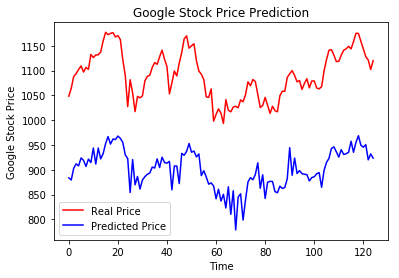

In [28]:
plt.plot(real_stock_price,color = 'red', label = 'Real Price')
plt.plot(predicted_price, color = 'blue', label = 'Predicted Price')
plt.title('Google Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Google Stock Price')
plt.legend()
plt.show()